In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

In [2]:
from utils import extract_page_text_content, launch_chromedriver
from models import HtmlPage, TextContainer, Figure
from pathlib import Path
from PIL import Image

pdf_samples_base = Path('../tests/data/sample_html_page/')
pdf_path = pdf_samples_base / "page4.html"

## Decipher code

In [3]:
import main
import utils

base_test_folder = Path('../tests')
output = base_test_folder / "output"
pdf1_path = base_test_folder / "data" / "pdf-2.pdf"
# xpdf_path  = base_test_folder / "output"



In [4]:
pil_images = main.fetch_pages_as_images(pdf_path=pdf1_path.resolve(), base_folder=output)

In [5]:
xpdf_folder_path = utils.pdf2html(pdf1_path.resolve(), output.resolve(), "pdf2")
# pages = main.get_pages(xpdf_path)

In [6]:
pages = main.get_pages(Path(xpdf_folder_path))

In [7]:
import math

def merge_left_padded_points(sorted_points: list[tuple[int, int]], padding_threshold=10) -> list[tuple[int, int]]:
    """ Update the sorted counts by merging padded text elements """
    left_points = sorted_points.copy()
    i = 0
    while i < len(left_points):
        j = i + 1
        while j < len(left_points):
            if abs(left_points[i][0] - left_points[j][0]) <= padding_threshold:
                left_points[i] = (left_points[i][0], left_points[i][1] + left_points[j][1])
                del left_points[j]
            else:
                j = j + 1
        i = i + 1
    return sorted(left_points, key=lambda x: x[1], reverse=True)

def get_columns_coordinates(sorted_left_points, row_width, page_width):
    # i don't think this is right...
    mode_first_left_point = sorted_left_points[0][1]
    print(mode_first_left_point)
    if float(mode_first_left_point) / len(sorted_left_points) > .75 or float(row_width) / page_width > .5:
        return [sorted_left_points[0][0]]
    else:
        # find starting point for second column
        for i in range(1, len(sorted_left_points)):
            if abs(sorted_left_points[i][0] - sorted_left_points[0][0]) > row_width:
                return [
                    min(sorted_left_points[i][0], sorted_left_points[0][0]),
                    max(sorted_left_points[i][0], sorted_left_points[0][0]),
                ]


def calculate_document_layout(pages: list[HtmlPage], width_threshold=30):
    """ Implements the document layout acquisition procedure from section 2.2 """
    x0s = [y.x0 for x in pages for y in x.text_containers if y.width > width_threshold]
    y0s = [y.y0 for x in pages for y in x.text_containers if y.width > width_threshold]
    x1s = [y.x1 for x in pages for y in x.text_containers if y.width > width_threshold]
    widths = [y.width for x in pages for y in x.text_containers if y.width > width_threshold]
    heights = [y.height for x in pages for y in x.text_containers if y.width > width_threshold]

    # sorting by most occurent value (mode) using tuples (width, count(width))
    sorted_x0s = sorted([(i, x0s.count(i)) for i in set(x0s)], key=lambda x: x[1], reverse=True)
    sorted_widths = sorted([(i, widths.count(i)) for i in set(widths)], key=lambda x: x[1], reverse=True)
    sorted_heights = sorted([(i, heights.count(i)) for i in set(heights)], key=lambda x: x[1], reverse=True)  

    row_height = sorted_heights[0][0]
    row_width = sorted_widths[0][0]

    # consider padding
    sorted_x0s = merge_left_padded_points(sorted_x0s)

    cr_x0 = sorted_x0s[0][0]
    cr_y0 = max(0, min(y0s))
    cr_x1 = max(x1s)
    cand_y1s = [y.y1 for x in pages for y in x.text_containers if y.x0 >= cr_x0 and y.x1 <= cr_x1 and y.y0 >= cr_y0]
    cr_y1 = max(cand_y1s)
    cr = [cr_x0, cr_y0, cr_x1 - cr_x0, cr_y1 - cr_y0]


    # calculate number of columns
    page_width = pages[0].width
    number_cols = math.floor(page_width / row_width)
    
    if number_cols == 1:
        cols_layout = [cr_x0]
    else: # restrict here to 2?
        candidates = [y.x0 for x in pages for y in x.text_containers if y.x0 >= cr_x0 + row_width]        
        cols_layout = [sorted_x0s[0][0], min(candidates)]

    # TODO: fix the columns coordinates... use page width and then search for starting x0
    # cols_layout = get_columns_coordinates(sorted_x0s, row_width, page_width)
    

    return cr, row_width, row_height, cols_layout


In [8]:
content_region, row_width, row_height, cols_layout = calculate_document_layout(pages)
number_cols = len(cols_layout)
content_region, cols_layout


([36, 24, 535, 745], [36, 296])

In [40]:

from typing import Optional

def draw_content_region(ax, content_region: list[int]):
  rect = patches.Rectangle((content_region[0], content_region[1]),
                            content_region[2], content_region[3],
                            linewidth=1,
                            edgecolor='black',
                            facecolor='none',
                            alpha=0.4)
  ax.add_patch(rect)


def draw_text_regions(ax, page: HtmlPage):
  for bbox in page.text_containers:
    rect = patches.Rectangle((bbox.x0, bbox.y0),
                            bbox.width, bbox.height,
                            linewidth=1,
                            edgecolor='blue',
                            facecolor='none',
                            alpha=0.4)
    ax.add_patch(rect)


def draw_figure_candidates(ax, bboxes):
  for bbox in bboxes:
    rect = patches.Rectangle((bbox[0], bbox[1]),
                            bbox[2], bbox[3],
                            linewidth=1,
                            edgecolor='red',
                            facecolor='red',
                            alpha=0.9)
    ax.add_patch(rect)


def draw_bboxes(ax, bboxes, edgecolor: Optional[str], facecolor: Optional[str], alpha: float):
  # bbox: [x0, y0, w, h]
  for bbox in bboxes:
    rect = patches.Rectangle((bbox[0], bbox[1]),
                            bbox[2], bbox[3],
                            linewidth=1,
                            edgecolor=edgecolor,
                            facecolor=facecolor if facecolor else 'null',
                            alpha=alpha)
    ax.add_patch(rect)

def draw_columns(ax, cols_layout, page_height):
  for col in cols_layout:
    ax.vlines(col, 0, page_height, colors="red", linestyles="dashed")



## Graphical content detection

In [10]:
from os import listdir
import cv2
import numpy as np
import re


def calc_img_scale(image, page_width, page_height):
    # the PNG may be bigger than the html size
    height, width, _ = image.shape
    if height > width:
      return float(height) / page_height
    else:
      return float(width) / page_width

def overlap_ratio_based(box1, box2):
    # overlap ratio based on box1
    box1_x0 = box1[0]
    box1_y0 = box1[1]
    box1_x1 = box1[0] + box1[2]
    box1_y1 = box1[1] + box1[3]

    box2_x0 = box2[0]
    box2_y0 = box2[1]
    box2_x1 = box2[0] + box2[2]
    box2_y1 = box2[1] + box2[3]

    SI = max(0, min(box1_x1, box2_x1) - max(box1_x0, box2_x0)) * max(
        0, min(box1_y1, box2_y1) - max(box1_y0, box2_y0)
    )
    box1_area = box1[2] * box1[3]    
    if box1_area == 0:
        overlap_ratio = 0
    else:
        overlap_ratio = float(SI) / box1_area
    return overlap_ratio

def detect_boxes(pages: list[HtmlPage], xpdf_path: str):    
    page_width = pages[0].width
    page_height = pages[0].height

    images = []

    for page in pages:
      ""
    

In [33]:
def estimate_number_figures(text_containers: list[TextContainer]):
  num_figs = 0
  for box in text_containers:
    rgx = re.search(r"\d+", box.text)
    if rgx is not None:
      num_figs = max(int(rgx.group()), num_figs)
  return num_figs


def filter_content_boxes(page: HtmlPage):
    """ Get containers with text matching Table or Fig """
    table_boxes = []
    figure_boxes = []
    for text_container in page.text_containers:
      text = text_container.text.lower().strip()
      if text.startswith("table") or text.startswith("box"):
        table_boxes.append(text_container)
      elif text.startswith("fig"):
        figure_boxes.append(text_container)
      else:
        text = text[:6].replace(" ", "")
        if text.startswith("fig"): figure_boxes.append(text_container)
    return figure_boxes, table_boxes


def get_potential_figure_bboxes(base_folder_path: str, page: HtmlPage, layout: list[int], row_height: int):
    """ Process the page image to find potential contours that hold figures """

    figure_boxes, table_boxes = filter_content_boxes(page)

    png_path = str((Path(base_folder_path) / page.img_name).resolve())
    page_image = cv2.imread(png_path)
    page_image_gray = cv2.cvtColor(page_image, cv2.COLOR_BGR2GRAY)
    # match PNG and html sizes
    scaling = calc_img_scale(page_image, page.width, page.height)

    _, thresh = cv2.threshold(page_image_gray, 240, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(thresh, kernel, iterations=1)
    contours, _ = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # canvas_with_contours = np.zeros(thresh.shape, dtype=np.uint8)

    potential_fig_bboxes = []
    for cnt in contours:
      cnt_bbox = cv2.boundingRect(cnt)
      scaled_cnt_bbox = [int(float(x) / scaling) for x in cnt_bbox]
      overlap_w_captions = 0
      for caption_box in figure_boxes:
        overlap_w_captions += overlap_ratio_based(caption_box.to_bbox(), scaled_cnt_bbox)
      overlap_w_layout = overlap_ratio_based(layout, scaled_cnt_bbox)
      layout_margin = 10

      box_height = scaled_cnt_bbox[3]
      if overlap_w_captions < 0.5 and overlap_w_layout < 0.2 and scaled_cnt_bbox[1] >= layout[1] - layout_margin and box_height > row_height:
          # cv2.drawContours(canvas_with_contours, [cnt], 0, 255, -1)
          potential_fig_bboxes.append(scaled_cnt_bbox)

    return potential_fig_bboxes, figure_boxes, table_boxes


def manhattan(a, b):
    return sum(abs(a - b) for a, b in zip(a, b))

def bbox_distance(bbox1, bbox2):
    x1 = bbox1[0]
    y1 = bbox1[1]
    x1b = bbox1[0] + bbox1[2]
    y1b = bbox1[1] + bbox1[3]
    x2 = bbox2[0]
    y2 = bbox2[1]
    x2b = bbox2[0] + bbox2[2]
    y2b = bbox2[1] + bbox2[3]
    left = x2b < x1
    right = x1b < x2
    bottom = y2b < y1
    top = y1b < y2
    if top and left:
        return manhattan((x1, y1b), (x2b, y2))
    elif left and bottom:
        return manhattan((x1, y1), (x2b, y2b))
    elif bottom and right:
        return manhattan((x1b, y1), (x2, y2b))
    elif right and top:
        return manhattan((x1b, y1b), (x2, y2))
    elif left:
        return x1 - x2b
    elif right:
        return x2 - x1b
    elif bottom:
        return y1 - y2b
    elif top:
        return y2 - y1b
    else:  # rectangles intersect
        return 0


def remove_tables_from_candidates(table_boxes: list[TextContainer], candidates: list):
    filtered_candidates = []
    for table_textbox in table_boxes:
      # the caption appears over the table
      fake_table_box_top = table_textbox.to_bbox()
      fake_table_box_top[3] = 4 * row_height # make it taller
      # the caption appears below the table
      fake_table_box_bottom = fake_table_box_top
      fake_table_box_bottom[1] = fake_table_box_bottom[1] - 4 * row_height

      for pot_fig_bbox in candidates:
        overlap_top = overlap_ratio_based(pot_fig_bbox, fake_table_box_top)
        overlap_bottom = overlap_ratio_based(pot_fig_bbox, fake_table_box_bottom)
        if overlap_top <= 0.1 and overlap_bottom <= 0.1:
          filtered_candidates.append(pot_fig_bbox)
    return filtered_candidates


def is_multicol_caption(box: TextContainer, page_width, row_width, cols_layout):
    ROW_EXTRA = row_width/5
    # if  box.width > row_width + ROW_EXTRA or (box.x0 < page_mid and box.x1 > page_mid):  
    if box.x1 > cols_layout[1] or box.x0 > cols_layout[1] + ROW_EXTRA:
      return True
    return False


def estimate_caption_regions_top(caption_boxes: list[TextContainer], num_columns: int, page_width: int, row_width: int, cols_layout: list, layout):
    """ Estimate the regions on top of a potential caption sentence. These 
        regions serve to indicate the potential locations of figures assuming 
        that these captions appear below the figure.
        The estimations are performed using a vertical sweep from top to bottom
        such that regions are assigned only to one caption box.
    """
    if len(caption_boxes) == 0: return []

    regions = []
    if num_columns == 1:
      vert_sweep = 1 # sweep through the whole row
      sorted_caption_boxes = sorted(caption_boxes, key=lambda x: x[1]) # by y0
      for box in sorted_caption_boxes:
        regions.append((box, [1, 1, page_width - 2, box.y0 - vert_sweep], False))
        vert_sweep = box.y0 + box.height
    elif num_columns == 2:
      sweep = [layout[1]] * num_columns # keep a sweep value per column
      sorted_caption_boxes = sorted(caption_boxes, key=lambda x: (x.y0, x.x0)) # by y0 and x0
      for box in sorted_caption_boxes:
        multicol_caption = is_multicol_caption(box, page_width, row_width, cols_layout)
        if multicol_caption:
          region = [layout[0], sweep[0], layout[3], box.y0 - sweep[0]]
          sweep[0] = box.y0 + box.height
        else:
          if box.x0 < cols_layout[1]:
            region = [box.x0, sweep[0], cols_layout[1]-cols_layout[0], box.y0 - sweep[0]]
            sweep[0] = box.y0 + box.height
          else:
            region = [box.x0, sweep[1], page_width - cols_layout[0], box.y0 - sweep[1]]
            sweep[1] = box.y0 + box.height
        regions.append((box, region, multicol_caption))
    else:
      print("skipping page: calculations do not support PDFs with more than 2 columns")      
    
    return regions


def estimate_caption_regions_bottom(caption_boxes: list[TextContainer], num_columns: int, page_width: int, row_width: int, cols_layout: list, layout):
    """ Estimate the regions below a potential caption sentence. The sweep is 
        done from bottom to top to avoid issues with multicolumn and single 
        column figures in a same page.
    """
    if len(caption_boxes) == 0: return []

    regions = []
    if num_columns == 1:
      vert_sweep = layout[1] + layout[3] # bottom
      sorted_caption_boxes = sorted(caption_boxes, key=lambda x: x[1], reverse=True) # by y0 desc
      for box in sorted_caption_boxes:
        regions.append((box, [cols_layout[0], box.y0 + box.height, page_width, vert_sweep - box.y0], False))
        vert_sweep = box.y0
    elif num_columns == 2:
      sweep = [layout[3]] * num_columns # keep a sweep value per column
      sorted_caption_boxes = sorted(caption_boxes, key=lambda x: (x.y0, x.x0), reverse=True) # by y0 and x0
      for box in sorted_caption_boxes:
        multicol_caption = is_multicol_caption(box, page_width, row_width, cols_layout)
        if multicol_caption:
          region = [cols_layout[0], box.y0+box.height, page_width, sweep[0] - box.y0]
          sweep[0] = box.y0
          sweep[1] = box.y0
        else:
          if box.x0 < cols_layout[1]:
            region = [box.x0, box.y0+box.height, cols_layout[1]-cols_layout[0], sweep[0] - box.y0]
            sweep[0] = box.y0
          else:
            region = [box.x0, box.y0+box.height, page_width - cols_layout[0], sweep[1] - box.y0]
            sweep[1] = box.y0
        regions.append((box, region, multicol_caption))
    else:
      print("skipping page: calculations do not support PDFs with more than 2 columns")      
    
    return regions


def estimate_caption_regions_side(caption_boxes: list[TextContainer], num_columns: int, row_width: int, cols_layout: list, layout):
    """ Estimate the regions when the caption is to the right or left of the
        figure. These cases contemplate only multi-column figures because 
        side captions on a single column may be unfeasible due to space 
        contraints.
    """
    if len(caption_boxes) == 0: return []
    regions = []
    # start at bottom to sweep bottom - up
    vert_sweep = layout[1] + layout[3] # bottom
    sorted_caption_boxes = sorted(caption_boxes, key=lambda x: (x.y0, x.x0), reverse=True)
    mid_point = cols_layout[0] + row_width/2 if num_columns==1 else cols_layout[1]

    for box in sorted_caption_boxes:
      if box.x0 < mid_point: # caption on the left
        region = [box.x0+box.width, box.y0, layout[2]-box.width, vert_sweep-box.y0]      
      else:
        region = [layout[0], box.y0, box.x0-layout[0], vert_sweep-box.y0]      
      vert_sweep = box.y0
      regions.append((box, region, True))
    
    return regions

def match_figures_with_captions(regions, candidates)-> list[Figure]:
    """ Match candidate regions for captions to candidate figures per page """
    # change the logic here. Every candidate figure inside the region can be
    # merged and be considered a figure.    
    figures = []
    unmatched_caption_boxes = []
    idxs_to_remove = []
    for caption_box, region_bbox, multicolumn in regions:
      # keep index for easy removal
      sparse_figures = [(idx, x) for idx, x in enumerate(candidates) if overlap_ratio_based(x, region_bbox) > 0.9]
      if len(sparse_figures) > 1:
        x0 = min([x[1][0] for x in sparse_figures])
        y0 = min([x[1][1] for x in sparse_figures])
        x1 = max([x[1][0]+x[1][2] for x in sparse_figures])
        y1 = max([x[1][1]+x[1][3] for x in sparse_figures])
        figure = Figure(x0=x0, y0=y0, width=x1-x0, height=y1-y0, caption=caption_box, multicolumn=multicolumn)
        figures.append(figure)
        idxs_to_remove += [x[0] for x in sparse_figures]
      else:
        unmatched_caption_boxes.append(caption_box)      
    
    remaining_candidates = [x for idx, x in enumerate(candidates) if idx not in idxs_to_remove]    
    return figures, unmatched_caption_boxes, remaining_candidates

def expand_captions(page: HtmlPage, figures: list[Figure], row_height: int):
    """ Search in the page for the next sentences to complement the caption """
    for figure in figures:
      sentences = [x for x in page.text_containers if x.y0 > figure.caption.y0 and abs(figure.caption.x0 - x.x0) < 10]
      sentences = sorted(sentences, key=lambda x: x.y0)
      vertical = figure.caption.y0 + figure.caption.height
      
      for sentence in sentences:
        if abs(sentence.y0 - vertical) < row_height:
          figure.caption.width = figure.caption.width if figure.caption.width >= sentence.width else sentence.width
          figure.caption.height += sentence.height
          # TODO: fix - symbols when breaking lines
          figure.caption.text += f" {sentence.text}"          
          vertical = sentence.y0 + sentence.height
        else:
          break        
    return figures


def remove_used_candidates(figures: list[Figure], candidates: list):
    updated_candidates = []



def match_figures_and_captions(caption_boxes: list[TextContainer], table_boxes: list[TextContainer], pot_fig_bboxes: list, page: HtmlPage, row_height: int, fig_threshold = 30):
    
    DISTANCE_FIG_CAPTION = 50    
    filtered_candidates = remove_tables_from_candidates(pot_fig_bboxes)

# TODO: fix table extraction
# TODO: get figure name, and check cases when no caption is found


    




page1.png
page2.png
page3.png
page4.png
	 Figure 1. CKD mice have defective glucose-stimulated insulin secretion in vivo. (A) Blood glucose and (B) AUC during an IPGTT (1 g/kg) in CKD orsham-operated mice. (C) Insulin levels during the IPGTT (n = 9–10). (D) Glucose levels during HGCs. (E) Insulin levels during HGCs and in response to anarginine bolus (1 mM/kg). (F) Mean insulin levels during the clamp (50–80 min). (G) Arginine-induced insulin secretion (AUC) from 80 to 90 minutes(n = 7). (H) Mean C-peptide during the clamp (50–80 min). (I) GIR during the clamp (50–80 min). Blood glucose (J) and kITT (K) during the IPITT (0.5 IU/kg)(n = 6–8). Data represent the mean ± SEM. *P < 0.05 and **P < 0.01 versus CKD for the same times; 2-way ANOVA with Bonferroni’s post-hoc test for A, C,D, E, and J and Student’s t test for B, F–I, and K.
page5.png
	 Figure 2. Isolated islets from CKD mice have reducedinsulin release in response to glucose and KCl. (A) Insulinsecretion, shown as the percentage 

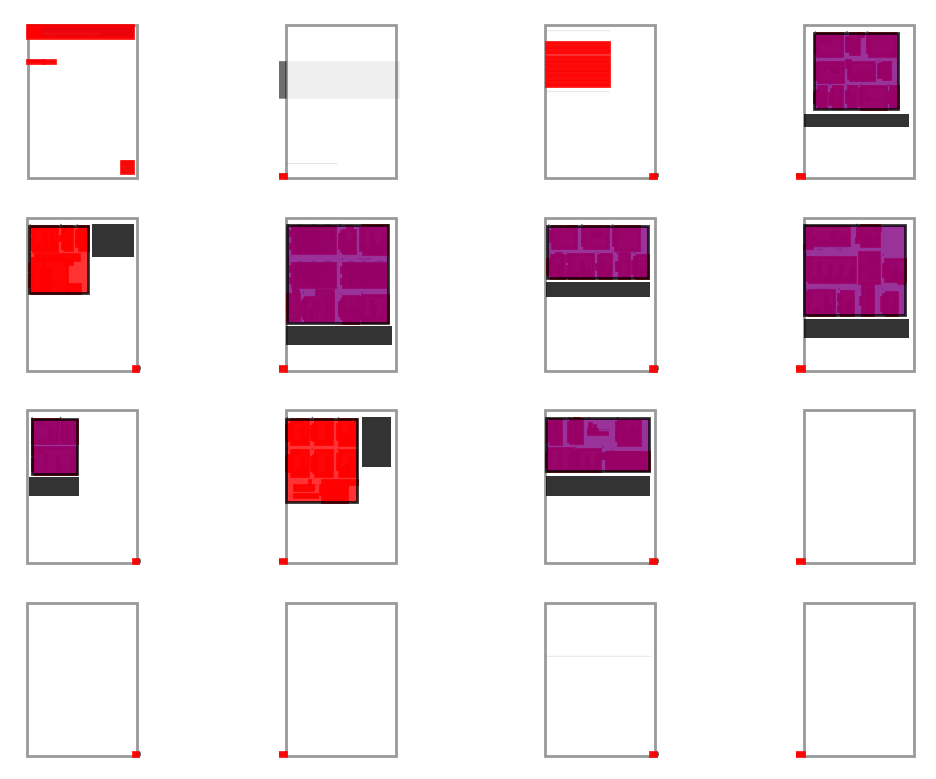

In [45]:
layout, row_width, row_height, cols_layout = calculate_document_layout(pages)
num_cols_in_doc = len(cols_layout)

number_cols = 4
number_rows = int(len(pages) / number_cols) 

_, ax = plt.subplots(number_rows, number_cols, dpi=200)

for idx, page in enumerate(pages):    
  page_name = page.img_name
  print(page_name)
  png_path = (Path(xpdf_folder_path) / page_name).resolve()

  col = idx % number_cols
  row = int(idx / number_cols)  

  page_image = Image.open(png_path)
  page_image = page_image.resize((page.width, page.height))
  draw_content_region(ax[row][col], content_region)  
  # draw_text_regions(ax[row][col], page)

  # probably don't filter by more height here yet, as some labels connect 
  # the figures
  candidates, fig_containers, table_containers = get_potential_figure_bboxes(xpdf_folder_path, page, layout, row_height)  
  draw_figure_candidates(ax[row][col], candidates)
  # draw_columns(ax[row][col], cols_layout, page.height)

  caption_bboxes = [x.to_bbox() for x in fig_containers]
  # draw_bboxes(ax[row][col], caption_bboxes, 'black', 'black', 1.0)  
  
  # process figures when captions are below the image
  regions = estimate_caption_regions_top(fig_containers, num_cols_in_doc, page.width, row_width, cols_layout, layout)
  figures_top, unmatch_caption_boxes, remaining_candidates = match_figures_with_captions(regions, candidates)  
  # check tables
  regions = estimate_caption_regions_bottom(table_containers, num_cols_in_doc, page.width, row_width, cols_layout, layout)
  tables, _, remaining_candidates = match_figures_with_captions(regions, remaining_candidates)
  # process figures when captions are on top of image
  regions = estimate_caption_regions_bottom(unmatch_caption_boxes, num_cols_in_doc, page.width, row_width, cols_layout, layout)
  figures_bottom, unmatch_caption_boxes, remaining_candidates = match_figures_with_captions(regions, remaining_candidates)  
  # finally check images when captions are on the sides
  regions = estimate_caption_regions_side(unmatch_caption_boxes, num_cols_in_doc, row_width, cols_layout, layout)
  figures_side, unmatch_caption_boxes, remaining_candidates = match_figures_with_captions(regions, remaining_candidates)  

  figures_top = expand_captions(page, figures_top, row_height)
  fig_bboxes_top = [x.to_bbox() for x in figures_top]
  captions = [x.caption.to_bbox() for x in figures_top]
  for figure in figures_top:
    print("\t", figure.caption.text)
  draw_bboxes(ax[row][col], fig_bboxes_top, 'black', 'purple', 0.8)
  draw_bboxes(ax[row][col], captions, None, 'black', 0.8)

  figures_bottom = expand_captions(page, figures_bottom, row_height)
  fig_bboxes_bottom = [x.to_bbox() for x in figures_bottom]
  captions = [x.caption.to_bbox() for x in figures_bottom]
  for figure in figures_bottom:
    print("\t", figure.caption.text)
  draw_bboxes(ax[row][col], captions, None, 'black', 0.8)

  fig_bboxes_side = [x.to_bbox() for x in figures_side]  
  
  draw_bboxes(ax[row][col], fig_bboxes_bottom, 'black', 'red', 0.8)
  draw_bboxes(ax[row][col], fig_bboxes_side, 'black', 'blue', 0.8)
  
  # expanded_figures = expand_captions(page, out_figures, row_height)

  # region_bboxes = [x[1] for x in regions]
  # print(region_bboxes)
  # draw_bboxes(ax[row][col], region_bboxes, 'blue', 'yellow', 0.5)

  # draw_bboxes(ax[row][col], out_figures, 'black', 'purple', 0.5)
  # expanded_fig_bboxes = [x.to_bbox() for x in expanded_figures]
  # expanded_captions = [x.caption.to_bbox() for x in expanded_figures]
  # draw_bboxes(ax[row][col], expanded_fig_bboxes, 'black', 'purple', 0.5)
  # draw_bboxes(ax[row][col], expanded_captions, 'black', 'green', 1)

  ax[row][col].imshow(page_image)
  ax[row][col].axis('off')




In [13]:
# base_folder_path = xpdf_folder_path
# page = pages[2]

# png_path = str((Path(base_folder_path) / page.img_name).resolve())
# page_image = cv2.imread(png_path)
# page_image_gray = cv2.cvtColor(page_image, cv2.COLOR_BGR2GRAY)
# scaling = calc_img_scale(page_image, page.width, page.height)

# _, thresh = cv2.threshold(page_image_gray, 240, 255, cv2.THRESH_BINARY_INV)
# kernel = np.ones((5, 5), np.uint8)
# dilation = cv2.dilate(thresh, kernel, iterations=1)
# contours, _ = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# canvas_with_contours = np.zeros(thresh.shape, dtype=np.uint8)

# potential_fig_bboxes = []
# for cnt in contours:
#   cnt_bbox = cv2.boundingRect(cnt)
#   scaled_cnt_bbox = [int(float(x) / scaling) for x in cnt_bbox]
#   overlap_w_captions = 0
#   overlap_w_layout = overlap_ratio_based(layout, scaled_cnt_bbox)
#   print(overlap_w_layout)
#   if overlap_w_layout < 0.2:
#     cv2.drawContours(canvas_with_contours, [cnt], 0, 255, -1)

# cv2.namedWindow("window", cv2.WINDOW_NORMAL)
# imS = cv2.resize(canvas_with_contours, (page.width, page.height))  
# cv2.imshow('window', imS)
# cv2.waitKey(0)
# cv2.destroyAllWindows()